In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# 1. Veri Önişleme
print("1. Veri Önişleme Aşaması")
print("-----------------------")

1. Veri Önişleme Aşaması
-----------------------


In [3]:
# Veri setini yükleme
labels = []
paths = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_name.split()[-1] != 'GT':
                labels.append(os.path.split(dir_name)[-1])
                paths.append(os.path.join(dir_name, filename))

data = pd.DataFrame({"path": paths, "label": labels})

In [4]:
# Veri seti hakkında bilgi
print("\nVeri Seti Özeti:")
print(f"Toplam görüntü sayısı: {len(data)}")
print("\nSınıf dağılımı:")
print(data['label'].value_counts())


Veri Seti Özeti:
Toplam görüntü sayısı: 9000

Sınıf dağılımı:
label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64


In [5]:
# Görüntü yükleme ve önişleme fonksiyonu
def load_and_preprocess_image(img_path, image_size=(128, 128)):
    try:
        with Image.open(img_path) as img:
            img = img.convert('RGB')
            img = img.resize(image_size)
            img_array = np.array(img) / 255.0  # Normalize
            return img_array
    except Exception as e:
        print(f"Hata: {img_path}: {str(e)}")
        return None

In [6]:
# Görüntüleri yükleme
IMAGE_SIZE = (128, 128)
images = []
valid_indices = []

print("\nGörüntüler yükleniyor...")


Görüntüler yükleniyor...


In [7]:
for idx, path in enumerate(data['path']):
    img = load_and_preprocess_image(path, IMAGE_SIZE)
    if img is not None:
        images.append(img)
        valid_indices.append(idx)
    if idx % 1000 == 0:
        print(f"İşlenen görüntü sayısı: {idx}")

İşlenen görüntü sayısı: 0
İşlenen görüntü sayısı: 1000
İşlenen görüntü sayısı: 2000
İşlenen görüntü sayısı: 3000
İşlenen görüntü sayısı: 4000
İşlenen görüntü sayısı: 5000
İşlenen görüntü sayısı: 6000
İşlenen görüntü sayısı: 7000
İşlenen görüntü sayısı: 8000


In [8]:
# Hatalı görüntüleri çıkar
data = data.iloc[valid_indices].reset_index(drop=True)
X = np.stack(images)

In [9]:
# Etiketleri kodla
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(data['label'])

In [10]:
# Veri setini böl
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
# One-hot encoding
y_train_cat = tf.keras.utils.to_categorical(y_train)
y_test_cat = tf.keras.utils.to_categorical(y_test)

In [12]:
# Farklı hiperparametreler için model oluşturma fonksiyonu
def create_model(layers, nodes, dropout_rate, learning_rate):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=IMAGE_SIZE + (3,)))
    
    for i in range(layers):
        model.add(tf.keras.layers.Dense(nodes, activation='relu'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(dropout_rate))
        nodes = nodes // 2  # Her katmanda düğüm sayısını azalt
    
    model.add(tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax'))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [13]:
# Hiperparametre kombinasyonları
hyperparameters = [
    {'layers': 3, 'nodes': 512, 'dropout_rate': 0.3, 'learning_rate': 1e-3},
    {'layers': 4, 'nodes': 1024, 'dropout_rate': 0.4, 'learning_rate': 1e-4},
    {'layers': 2, 'nodes': 256, 'dropout_rate': 0.2, 'learning_rate': 1e-3}
]

In [14]:
# Her hiperparametre kombinasyonu için model eğitimi
best_val_acc = 0
best_model = None
best_history = None
best_params = None

In [15]:
for params in hyperparameters:
    print(f"\nHiperparametreler test ediliyor: {params}")
    
    model = create_model(
        layers=params['layers'],
        nodes=params['nodes'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )
    
    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=1e-6
        )
    ]
    
    history = model.fit(
        X_train, y_train_cat,
        batch_size=32,
        epochs=20,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    
    # En iyi modeli kaydet
    val_acc = max(history.history['val_accuracy'])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = model
        best_history = history
        best_params = params

print("\n3. En İyi Model Değerlendirmesi")
print("------------------------------")


Hiperparametreler test ediliyor: {'layers': 3, 'nodes': 512, 'dropout_rate': 0.3, 'learning_rate': 0.001}


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 55s 289ms/step - accuracy: 0.2988 - loss: 2.2150 - val_accuracy: 0.4139 - val_loss: 2.0036 - learning_rate: 0.0010
Epoch 2/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 51s 285ms/step - accuracy: 0.5567 - loss: 1.2890 - val_accuracy: 0.7076 - val_loss: 0.8568 - learning_rate: 0.0010
Epoch 3/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 51s 283ms/step - accuracy: 0.6637 - loss: 0.9579 - val_accuracy: 0.6729 - val_loss: 0.8989 - learning_rate: 0.0010
Epoch 4/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 83s 287ms/step - accuracy: 0.7259 - loss: 0.7849 - val_accuracy: 0.6986 - val_loss: 0.8028 - learning_rate: 0.0010
Epoch 5/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 51s 283ms/step - accuracy: 0.7906 - loss: 0.5955 - val_accuracy: 0.6438 - val_loss: 1.0259 - learning_rate: 0.0010
Epoch 6/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 52s 287ms/step - accuracy: 0.8197 - loss: 0.5251 - val_accuracy: 0.8083 - val_loss: 0.5577 - learning_rate: 0.0010
Epoch 7/20
180/180 ━━━━━━━━━━━━━━━━━━━━ 51s 284ms/step - accuracy: 0.8

In [16]:
# En iyi modelin test performansı
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_cat)
print(f"\nTest Kaybı: {test_loss:.4f}")
print(f"Test Doğruluğu: {test_accuracy:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9546 - loss: 0.1300

Test Kaybı: 0.1462
Test Doğruluğu: 0.9528


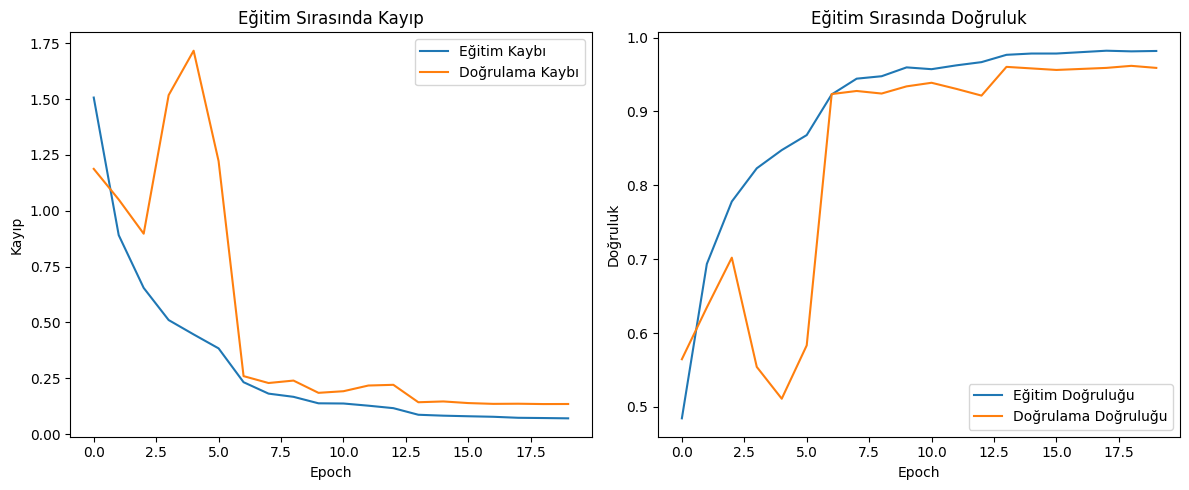

In [17]:
# Eğitim geçmişi grafiği
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(best_history.history['loss'], label='Eğitim Kaybı')
plt.plot(best_history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Eğitim Sırasında Kayıp')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(best_history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(best_history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Eğitim Sırasında Doğruluk')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()

plt.tight_layout()
plt.show()

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


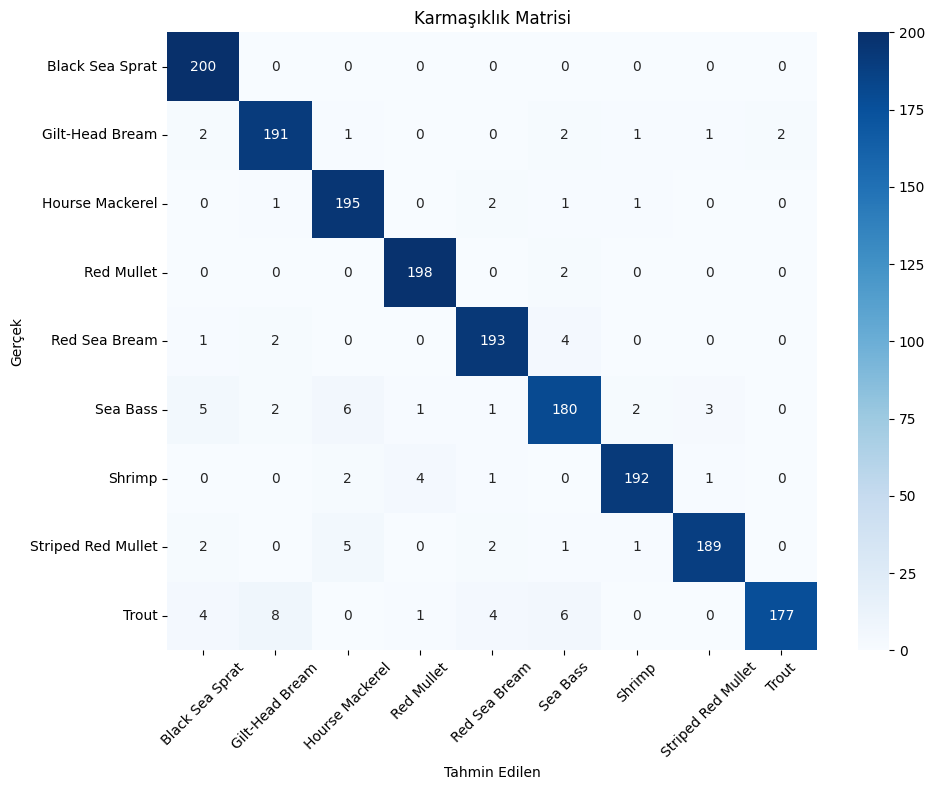

In [18]:
# Karmaşıklık matrisi
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Karmaşıklık Matrisi')
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
# Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(
    y_test,
    y_pred_classes,
    target_names=label_encoder.classes_
))


Sınıflandırma Raporu:
                    precision    recall  f1-score   support

   Black Sea Sprat       0.93      1.00      0.97       200
   Gilt-Head Bream       0.94      0.95      0.95       200
   Hourse Mackerel       0.93      0.97      0.95       200
        Red Mullet       0.97      0.99      0.98       200
     Red Sea Bream       0.95      0.96      0.96       200
          Sea Bass       0.92      0.90      0.91       200
            Shrimp       0.97      0.96      0.97       200
Striped Red Mullet       0.97      0.94      0.96       200
             Trout       0.99      0.89      0.93       200

          accuracy                           0.95      1800
         macro avg       0.95      0.95      0.95      1800
      weighted avg       0.95      0.95      0.95      1800



In [20]:
print("\nEn İyi Hiperparametreler:")
print(best_params)


En İyi Hiperparametreler:
{'layers': 2, 'nodes': 256, 'dropout_rate': 0.2, 'learning_rate': 0.001}
